In [15]:
import warnings 
warnings.filterwarnings("ignore")

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
import os
import glob
import cv2
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
from sklearn.utils import shuffle

from PIL import Image

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import imgaug as ia
from imgaug import augmenters as iaa


In [18]:
tf.__version__

'2.3.0'

In [19]:
def plotImages(artist, directory):
    """Plot 25 images of an artist."""
    multipleImages = glob.glob(directory)
    
    print(f"{artist} has {len(multipleImages)} images")
    plt.rcParams['figure.figsize'] = (12, 12)
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for l in multipleImages[:25]:
        im = cv2.imread(l)
        
        # Shrink image if too large
        try:
            im = cv2.resize(im, (128, 128))
            plt.subplot(5, 5, i_+1) #.set_title(l)
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        except:
            print(l)
            pass
        i_ += 1
    plt.savefig(f"{artist}.jpg")

In [20]:

%config InlineBackend.figure_format="svg"
%matplotlib inline


# Reproducibility is importatnt. Always set the seed!
seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)
ia.seed(seed)

In [21]:
import os
os.getcwd()

'C:\\Users\\can34\\Desktop\\워밍업 프로젝트\\스케치 이미지화 프로젝트\\artist_model'

In [22]:
# path = '/content/drive/My Drive/my_drive/'

In [23]:
# df = pd.read_csv('artists.csv', index_col=0)

In [24]:
# df.head()

In [25]:
# names = list(df['name'].unique())
# print(len(names))
# sorted(names)

In [26]:
# artists = df['name'].values.tolist()
# for artist in artists:  
#     artists = [artist.replace(" ", "_") for artist in artists] # match convention used in folder names
# artists

In [13]:
all_images_folders = glob.glob("webtoon_images/*")
all_images_folders[:5]

['webtoon_images\\갓오브하이스쿨-박용제',
 'webtoon_images\\다이스-윤현석',
 'webtoon_images\\제로게임-즐바센']

In [14]:
folders =[]
counts = []
count = 0
for dir_ in all_images_folders:
    folders.append(dir_.split('\\')[-1])
    counts.append(count)
    count +=1
print(len(folders))
folders

3


['갓오브하이스쿨-박용제', '다이스-윤현석', '제로게임-즐바센']

In [15]:
images = []
for folder in folders:
    images.extend(glob.glob("webtoon_images/"+str(folder)+"/*", recursive=True))

print(len(images))

18000


In [16]:
dic = {}
dic["name"] = folders
dic["label"] = counts
dic_df = pd.DataFrame(dic)
dic_df

,name,label
0,갓오브하이스쿨-박용제,0
1,다이스-윤현석,1
2,제로게임-즐바센,2


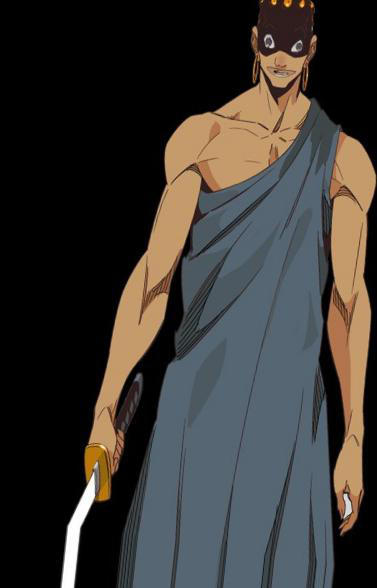

In [17]:
img_1 = Image.open(images[0])
img_1

In [18]:
imgs_df = pd.DataFrame(images)
dic_df
imgs_df

,0
0,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpeg
1,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpg
2,webtoon_images/갓오브하이스쿨-박용제\갓오하 (10).jpeg
3,webtoon_images/갓오브하이스쿨-박용제\갓오하 (100).jpeg
4,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1000).jpeg
...,...
17995,webtoon_images/제로게임-즐바센\clone_9_0_1550.jpeg
17996,webtoon_images/제로게임-즐바센\clone_9_0_3078.jpeg
17997,webtoon_images/제로게임-즐바센\clone_9_0_4432.jpeg
17998,webtoon_images/제로게임-즐바센\clone_9_0_7669.jpeg


In [19]:
imgs_df.columns = ['filename']
imgs_df

,filename
0,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpeg
1,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpg
2,webtoon_images/갓오브하이스쿨-박용제\갓오하 (10).jpeg
3,webtoon_images/갓오브하이스쿨-박용제\갓오하 (100).jpeg
4,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1000).jpeg
...,...
17995,webtoon_images/제로게임-즐바센\clone_9_0_1550.jpeg
17996,webtoon_images/제로게임-즐바센\clone_9_0_3078.jpeg
17997,webtoon_images/제로게임-즐바센\clone_9_0_4432.jpeg
17998,webtoon_images/제로게임-즐바센\clone_9_0_7669.jpeg


In [20]:
artist_name = []
for data in imgs_df["filename"]:
    data = data.replace("\\","/")
    data = data.split("/")
    artist_name.append(data[-2])
# print(artist_name)
imgs_df['name'] = artist_name

In [21]:
imgs_df

,filename,name
0,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpeg,갓오브하이스쿨-박용제
1,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpg,갓오브하이스쿨-박용제
2,webtoon_images/갓오브하이스쿨-박용제\갓오하 (10).jpeg,갓오브하이스쿨-박용제
3,webtoon_images/갓오브하이스쿨-박용제\갓오하 (100).jpeg,갓오브하이스쿨-박용제
4,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1000).jpeg,갓오브하이스쿨-박용제
...,...,...
17995,webtoon_images/제로게임-즐바센\clone_9_0_1550.jpeg,제로게임-즐바센
17996,webtoon_images/제로게임-즐바센\clone_9_0_3078.jpeg,제로게임-즐바센
17997,webtoon_images/제로게임-즐바센\clone_9_0_4432.jpeg,제로게임-즐바센
17998,webtoon_images/제로게임-즐바센\clone_9_0_7669.jpeg,제로게임-즐바센


In [22]:
final_df = pd.merge(imgs_df, dic_df)
final_df.head()

,filename,name,label
0,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpeg,갓오브하이스쿨-박용제,0
1,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1).jpg,갓오브하이스쿨-박용제,0
2,webtoon_images/갓오브하이스쿨-박용제\갓오하 (10).jpeg,갓오브하이스쿨-박용제,0
3,webtoon_images/갓오브하이스쿨-박용제\갓오하 (100).jpeg,갓오브하이스쿨-박용제,0
4,webtoon_images/갓오브하이스쿨-박용제\갓오하 (1000).jpeg,갓오브하이스쿨-박용제,0


In [23]:
##이미지 시각화 부분
# artist_index = 0
# # print(folders)
# folder = folders[artist_index]
# # print(folder)
# artist = folder.split("\\")[-1]
# print(artist)
# plotImages(artist,"webtoon_images/"+ folder+"/*.jpg")

In [24]:
train_df = final_df
train_df = shuffle(train_df)
train_df.head()

,filename,name,label
16840,webtoon_images/제로게임-즐바센\clone_792_0_408.jpeg,제로게임-즐바센,2
11810,webtoon_images/다이스-윤현석\clone_943_0_9656.jpeg,다이스-윤현석,1
11866,webtoon_images/다이스-윤현석\clone_960_0_612.jpeg,다이스-윤현석,1
4900,webtoon_images/갓오브하이스쿨-박용제\갓오하 (5408).jpeg,갓오브하이스쿨-박용제,0
15262,webtoon_images/제로게임-즐바센\clone_507_0_7725.jpeg,제로게임-즐바센,2


In [25]:
train_df['name'].describe()

count           18000
unique              3
top       갓오브하이스쿨-박용제
freq             6000
Name: name, dtype: object

## Setup DataGenerator

In [26]:
# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3

In [27]:
VALIDATION_SPLIT = 0.25
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=VALIDATION_SPLIT)

In [28]:
# batch size for training
batch_size=64

# total number of classes in the dataset
nb_classes= len(folders)

In [29]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="name",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224),
#     preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

Found 13500 validated image filenames belonging to 3 classes.


In [30]:
valid_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="name",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224),
#     preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)


Found 4500 validated image filenames belonging to 3 classes.


## Data Augmentation

In [31]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

## Modelling

In [32]:
def get_base_model():
    # base_model =  tf.keras.applications.vgg16.VGG16(input_shape=(img_rows, img_cols, img_channels), 
    #                    weights='imagenet', 
    #                    include_top=True)
    base_model = tf.keras.applications.ResNet152(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_rows, img_cols, img_channels),
    pooling=None,
    classes=1000)
    return base_model



# get the base model
base_model = get_base_model()

#  get the output of the second last dense layer 
base_model_output = base_model.layers[-2].output

# add new layers 
x = L.Dropout(0.5,name='drop2')(base_model_output)
output = L.Dense(nb_classes, activation='softmax', name='fc3')(x)

In [33]:
# define a new model 
model = tf.keras.Model(base_model.input, output)

# Freeze all the base model layers 
for layer in base_model.layers[:-1]:
    layer.trainable=False

# compile the model and check it 
optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 58,377,091
Trainable params: 6,147
Non-trainable params: 58,370,944
__________________________________________________________________________________________________


In [34]:
# Use earlystopping 
es = tf.keras.callbacks.EarlyStopping(patience=10, monitor = "val_accuracy", mode = "max",restore_best_weights=True)

# checkpoint to save model
chkpt = tf.keras.callbacks.ModelCheckpoint(filepath="art_model.h5", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(int(len(train_df) * (1-VALIDATION_SPLIT))/batch_size))
print(nb_train_steps)

nb_valid_steps = int(np.ceil(int(len(train_df) * VALIDATION_SPLIT)/batch_size))
print(nb_valid_steps)

# number of epochs 
nb_epochs=100

211
71


In [35]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [36]:
#train the model 
history1 = model.fit_generator(train_generator,
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_generator,
                              validation_steps=nb_valid_steps,
                              callbacks=[es,chkpt])

Epoch 1/100


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [ ]:
# # 6. 모델 저장하기
# from keras.models import load_model
# # Save model with json format
# model_json = model.to_json()
# with open("webtoon_model.json", "w") as json_file:
#     json_file.write(model_json)

# # Save weight with h5 format
# model.save_weights("webtoon_model.h5")
# print("artist_model")

In [ ]:
# #모델 불러오기
# from tensorflow.compat.v2.keras.models import model_from_json

# # model.json 파일 열기
# json_file = open("webtoon_model.json", "r") 
# loaded_model_json = json_file.read()
# json_file.close()

# # json파일로부터 model 로드하기
# loaded_model = model_from_json(loaded_model_json)


# # 로드한 model에 weight 로드하기
# loaded_model.load_weights("webtoon_model.h5")
# print("Loaded model from disk")

In [ ]:
#모델 전체를 h5형식으로 저장하기
# 6. 모델 저장하기
from keras.models import load_model
model.save('webtoon_model.h5')

In [9]:
#h5 형식으로 모델 불러오기
from keras.models import load_model
model = load_model('webtoon_model.h5')

In [ ]:

# let's plot the loss and accuracy 

# get the training and validation accuracy from the history object
train_acc = history1.history['accuracy']
valid_acc = history1.history['val_accuracy']

# get the loss
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']

# get the number of entries
xvalues = np.arange(len(train_acc))

# visualize
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

## Model Interpretability

In [ ]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:100]]

# Define a new model that generates the above output
vis_model = tf.keras.Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

In [ ]:
# def get_CAM(processed_image, predicted_label, layer_name='block5_conv3'):
#     """
#     This function is used to generate a heatmap for a sample image prediction.
    
#     Args:
#         processed_image: any sample image that has been pre-processed using the 
#                        `preprocess_input()`method of a keras model
#         predicted_label: label predicted by the network for this image
    
#     Returns:
#         heatmap: heatmap generated over the last convolution layer output 
#     """
    
#     # this will be the model that would give us the graidents
#     model_grad = tf.keras.Model([model.inputs], 
#                        [model.get_layer(layer_name).output, model.output])
    
#     # Gradient tape gives you everything you need
#     with tf.GradientTape() as tape:
#         conv_output_values, predictions = model_grad(processed_image)
#         loss = predictions[:, predicted_label]
    
#     # get the gradients wrt to the chosen layer
#     grads_values = tape.gradient(loss, conv_output_values)
    
#     # take mean gradient per feature map
#     grads_values = K.mean(grads_values, axis=(0,1,2))
    
#     # convert to numpy. This is done just for image operations.
#     # Check for shapes and you would understand why we performed 
#     # the squeeze operation here.
#     conv_output_values = np.squeeze(conv_output_values.numpy())
#     grads_values = grads_values.numpy()
    
    
#     # iterate over each feature map in yout conv output and multiply
#     # the gradient values with the conv output values. This gives an 
#     # indication of "how important a feature is"
#     for i in range(512): # we have 512 features in our last conv layer
#         conv_output_values[:,:,i] *= grads_values[i]
    
#     # create a heatmap
#     heatmap = np.mean(conv_output_values, axis=-1)
    
#     # remove negative values
#     heatmap = np.maximum(heatmap, 0)
    
#     # normalize
#     heatmap /= heatmap.max()
    
#     del model_grad, conv_output_values, grads_values, loss
   
#     return heatmap

In [ ]:
# def show_random_sample(idx):
#     """
#     This function is used to select a random sample from the validation dataframe.
#     It generates prediction for the same. It also stores the heatmap and the intermediate
#     layers activation maps.
    
#     Arguments:
#         idx: random index to select a sample from validation data
    
#     Returns:
#         activations: activation values for intermediate layers
#     """
#     # select the sample and read the corresponding image and label
#     sample_image = cv2.imread(train_df.iloc[idx]['filename'])
#     sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
#     sample_image = cv2.resize(sample_image, (img_rows, img_cols))
#     sample_label = train_df.iloc[idx]["name"]
    
#     # pre-process the image
#     sample_image_processed = np.expand_dims(sample_image, axis=0)
#     sample_image_processed = tf.keras.applications.vgg16.preprocess_input(sample_image_processed)
    
#     # generate activation maps from the intermediate layers using the visualization model
#     activations = vis_model.predict(sample_image_processed)
    
#     # get the label predicted by our original model
#     print(model.predict(sample_image_processed))
#     pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
#     # choose any random activation map from the activation maps 
#     sample_activation = activations[0][0,:,:,16]
    
#     # normalize the sample activation map
#     sample_activation-=sample_activation.mean()
#     sample_activation/=sample_activation.std()
    
#     # convert pixel values between 0-255
#     sample_activation *=255
#     sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    
    
#     # get the heatmap for class activation map(CAM)
#     heatmap = get_CAM(sample_image_processed, pred_label)
#     heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
#     heatmap = heatmap *255
#     heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     super_imposed_image = heatmap * 0.5 + sample_image
#     super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

#     f,ax = plt.subplots(2,2, figsize=(15,8))
#     ax[0,0].imshow(sample_image)
#     ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
#     ax[0,0].axis('off')
    
#     ax[0,1].imshow(sample_activation)
#     ax[0,1].set_title("Random feature map")
#     ax[0,1].axis('off')
    
#     ax[1,0].imshow(heatmap)
#     ax[1,0].set_title("Class Activation Map")
#     ax[1,0].axis('off')
    
#     ax[1,1].imshow(super_imposed_image)
#     ax[1,1].set_title("Activation map superimposed")
#     ax[1,1].axis('off')
#     plt.show()
    
#     return activations

In [ ]:
# _ = show_random_sample(idx=1)

In [ ]:
# _ = show_random_sample(idx=5)

In [ ]:
# _ = show_random_sample(idx=123)

In [ ]:
# _ = show_random_sample(idx=100)

In [ ]:
# _ = show_random_sample(idx=200)

In [ ]:
# _ = show_random_sample(idx=300)

In [ ]:
# _ = show_random_sample(idx=400)

In [ ]:
# activations = show_random_sample(idx=2000)

In [ ]:
# def visualize_intermediate_activations(layer_names, activations):
#     """
#     This function is used to visualize all the itermediate activation maps
    
#     Arguments:
#         layer_names: list of names of all the intermediate layers we chose
#         activations: all the intermediate activation maps 
#     """
#     assert len(layer_names)==len(activations), "Make sure layers and activation values match"
#     images_per_row=16
    
#     for layer_name, layer_activation in zip(layer_names, activations):
#         nb_features = layer_activation.shape[-1]
#         size= layer_activation.shape[1]

#         nb_cols = nb_features // images_per_row
#         grid = np.zeros((size*nb_cols, size*images_per_row))

#         for col in range(nb_cols):
#             for row in range(images_per_row):
#                 feature_map = layer_activation[0,:,:,col*images_per_row + row]
#                 feature_map -= feature_map.mean()
#                 feature_map /= feature_map.std()
#                 feature_map *=255
#                 feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

#                 grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

#         scale = 1./size
#         plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
#         plt.title(layer_name)
#         plt.grid(False)
#         plt.imshow(grid, aspect='auto', cmap='viridis')
#     plt.show()

In [ ]:
# visualize_intermediate_activations(activations=activations, 
#                                    layer_names=layer_names)

In [ ]:
# model.evaluate(valid_generator)

In [ ]:
# print("-- Predict --")
# output = model.predict_generator(valid_generator, steps=5)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# print(output)

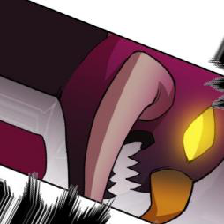

In [11]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
img_path = 'webtoon_images/1/clone_8_0_2447.jpeg'
img = load_img(img_path, target_size=(224, 224)) 
img

In [12]:
# ResNet에 입력하기 전에 이미지 전처리
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print(x)


[[[[ 34.  19.  26.]
   [ 34.  19.  26.]
   [ 34.  19.  26.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[ 34.  19.  26.]
   [ 34.  19.  26.]
   [ 34.  19.  26.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[ 34.  19.  26.]
   [ 34.  19.  26.]
   [ 34.  19.  26.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[ 94.  94.  94.]
   [116. 116. 116.]
   [217. 217. 217.]
   ...
   [193. 181. 191.]
   [193. 181. 191.]
   [192. 180. 190.]]

  [[103. 103. 103.]
   [211. 211. 211.]
   [228. 228. 228.]
   ...
   [195. 183. 193.]
   [195. 183. 193.]
   [195. 183. 193.]]

  [[161. 161. 161.]
   [230. 230. 230.]
   [205. 205. 205.]
   ...
   [197. 185. 195.]
   [197. 185. 195.]
   [196. 184. 194.]]]]


In [13]:
# 이미지 분류
preds = model.predict(x)
# print('Predicted:', decode_predictions(preds, top=3)[0])
output = model.predict(x)
# print(valid_generator.class_indices)
print(output)


[[2.99357653e-01 4.52296576e-04 1.59562251e-03 1.50570813e-07
  2.21030531e-03 1.73441789e-04 3.47740483e-03 2.01411007e-04
  1.83839463e-02 5.75975189e-03 5.00695842e-06 7.75080472e-02
  3.55258584e-02 1.09685876e-04 2.56305188e-02 5.29235065e-01
  1.60168274e-05 3.57719604e-04]]


In [ ]:
# # 결과를 json 파일 형식으로 만듬.
# import json
# print(valid_generator.class_indices.keys())
# print(valid_generator.class_indices.values())
# # for value in valid_generator.class_indices.values():
# inv_map = {v : k for k, v in valid_generator.class_indices.items()}
# with open('sample.json', 'w', encoding='utf-8') as f:
#     json.dump(inv_map ,f, ensure_ascii=False)
# with open('sample.json','r', encoding='utf-8') as file:
#     labelInfo = json.load(file)
# labelInfo

In [14]:
artist_lst = list(valid_generator.class_indices.keys())
# print(artist_lst)
output_data = list(output[0])
# print(output_data)
final_lst = []
for i in range(0,len(artist_lst)):
    dic = {"artist":artist_lst[i],
           "output":round(output_data[i],3)}
    final_lst.append(dic)
# print(final_lst)
result = sorted(final_lst, key=lambda x:x['output'], reverse=True)
print(result)
print("\n")
for i in range(1,4):
    print("{}번째로 가장 유사한 작가는 {}입니다.".format(i,result[i-1]["artist"]))

NameError: name 'valid_generator' is not defined